# Analyse de mes parties d'échecs (Chess.com)

J’ai exporté toutes mes parties depuis Chess.com afin d’analyser mon style de jeu.  
Le nombre de parties analysées est : 9094

Objectifs de ce notebook :
- Voir mes résultats globaux (victoires/défaites/nuls).
- Comparer mes performances avec les Blancs et les Noirs.
- Identifier mes ouvertures les plus jouées et leur efficacité.
- Étudier l’évolution de mon Elo au fil du temps.
- M'améliorer dans l'analyse de données.

Dataset : `my_chess_games_and_openings.csv`


In [115]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/kaggle/input/chess-games/my_chess_games_and_openings.csv")
df.head()



,utc_date,utc_time,color,opponent,my_elo,opponent_elo,eco,opening_raw,opening_family,time_control,termination,result,datetime
0,2020.06.30,04:57:09,white,FeloCruz1235,772,710,C40,NaN,Ouverture du Cavalier Roi,300,Requial won by checkmate,win,2020-06-30 04:57:09
1,2020.06.30,04:50:28,black,FeloCruz1235,762,717,B01,NaN,Scandinave,300,Requial won by checkmate,win,2020-06-30 04:50:28
2,2020.06.30,04:43:50,black,andyu22,751,732,B00,NaN,1.e4 Autres,300,andyu22 won by resignation,loss,2020-06-30 04:43:50
3,2020.06.30,04:33:51,white,andyu22,764,723,B20,NaN,Sicilienne,300,Requial won on time,win,2020-06-30 04:33:51
4,2020.06.30,04:27:14,white,KoreNeRD,752,757,C20,NaN,Jeu du pion roi,300,KoreNeRD won by resignation,loss,2020-06-30 04:27:14


In [116]:
# --- 1) Déduire la cadence à partir de time_control ---
# On estime le "temps total pour 40 coups" = base + 40*increment (méthode lichess)
def classify_tc(tc: str) -> str:
    try:
        tc = str(tc)
        if "+" in tc:
            base, inc = tc.split("+")
        else:
            base, inc = tc, "0"
        base = int(base)       # Chess.com donne des secondes
        inc  = int(inc)
        est  = base + 40*inc   # temps estimé pour 40 coups

        if est < 180:         # < 3 min
            return "Bullet"
        elif est < 480:       # 3–8 min
            return "Blitz"
        elif est < 1500:      # 8–25 min
            return "Rapide"
        else:                 # ≥ 25 min
            return "Classique"
    except:
        return "Inconnu"

df["cadence"] = df["time_control"].apply(classify_tc)
df["score"]   = df["result"].map({"win":1, "draw":0.5, "loss":0})
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")


# Résultats des parties
Ici on peut voir la différence win/loose/draw parmis les 9094 parties analysées ainsi qu'en pourcentage.

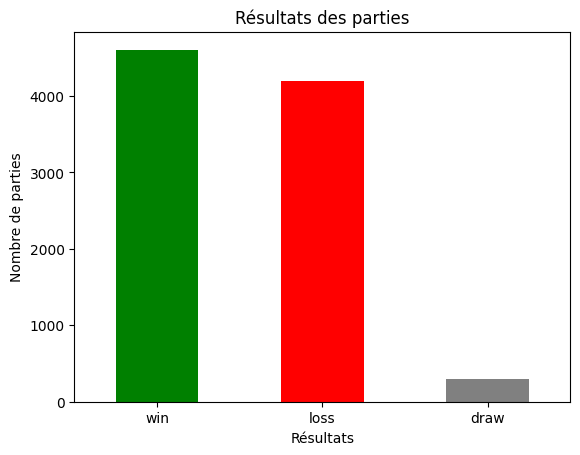

Résultats globaux :
 result
win     4604
loss    4189
draw     301
Name: count, dtype: int64


In [117]:
res_counts = df["result"].value_counts()

ax = res_counts.plot(kind="bar", color=["green","red","gray"], rot=0)
plt.title("Résultats des parties")
plt.xlabel("Résultats")
plt.ylabel("Nombre de parties")
plt.show()

print("Résultats globaux :\n", res_counts)


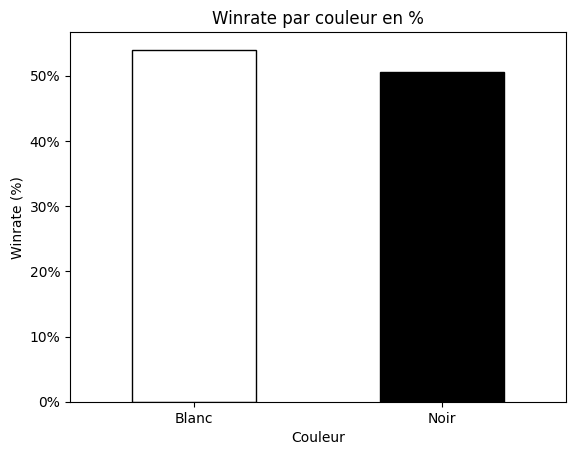

In [118]:
import matplotlib.ticker as mtick

# Remapper les noms
df["couleur"] = df["color"].map({"white": "Blanc", "black": "Noir"})

# Winrate par couleur en %
color_winrate = df.groupby("couleur")["score"].mean() * 100

# Réordonner pour afficher Blanc à gauche
color_winrate = color_winrate.reindex(["Blanc", "Noir"])

ax = color_winrate.plot(kind="bar", color=["#ffffff", "#000000"], edgecolor="black", rot=0)
plt.title("Winrate par couleur en %")
plt.xlabel("Couleur")
plt.ylabel("Winrate (%)")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()



**Ici on peut observer que j'ai une meilleure chance en jouant les blancs que les noirs**

# Ouvertures utilisées
Dans ce chapitre, on verra les ouvertures que j'ai le plus utilisées lors de mon aventure.

In [119]:
# Fonction pour fusionner les variantes proches
def simplify_opening(name):
    if not isinstance(name, str):
        return "Inconnue"
    name = name.strip()
    if name.startswith("Gambit Roi"):
        return "Gambit Roi"
    if name.startswith("Sicilienne"):
        return "Sicilienne"
    if name.startswith("Espagnole") or name.startswith("Ruy Lopez"):
        return "Espagnole"
    if name.startswith("Italienne"):
        return "Italienne"
    # tu peux ajouter d'autres regroupements selon ton style de jeu
    return name

# Nouvelle colonne simplifiée
df["opening_simplified"] = df["opening_family"].apply(simplify_opening)


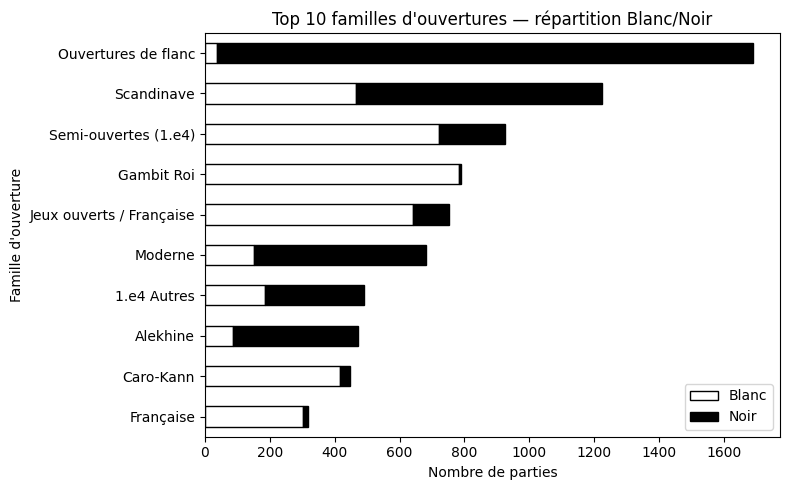

In [120]:
import matplotlib.pyplot as plt

# 1) Sélectionne les 10 familles les plus jouées (total Blanc+Noir)
fam_top = (df["opening_family"].fillna("Inconnue")
           .value_counts()
           .head(10)
           .index)

sub = df[df["opening_family"].fillna("Inconnue").isin(fam_top)].copy()
sub["fam"] = sub["opening_family"].fillna("Inconnue")

# 2) Tableau volumes par famille x couleur
counts = (sub.groupby(["fam","color"])
              .size()
              .unstack(fill_value=0)[["white","black"]])

# 3) Trier par total décroissant et inverser l’axe Y (plus joué en haut)
counts["total"] = counts["white"] + counts["black"]
counts = counts.sort_values("total", ascending=False).drop(columns="total")

# 4) Barres empilées (même ligne pour Blanc et Noir)
ax = counts.plot(kind="barh",
                 stacked=True,
                 color=["#ffffff", "#000000"],
                 edgecolor="black",
                 figsize=(8,5))

plt.title("Top 10 familles d'ouvertures — répartition Blanc/Noir")
plt.xlabel("Nombre de parties")
plt.ylabel("Famille d'ouverture")
plt.legend(labels=["Blanc","Noir"], loc="lower right")
plt.gca().invert_yaxis()  # la plus jouée en haut
plt.tight_layout()
plt.show()


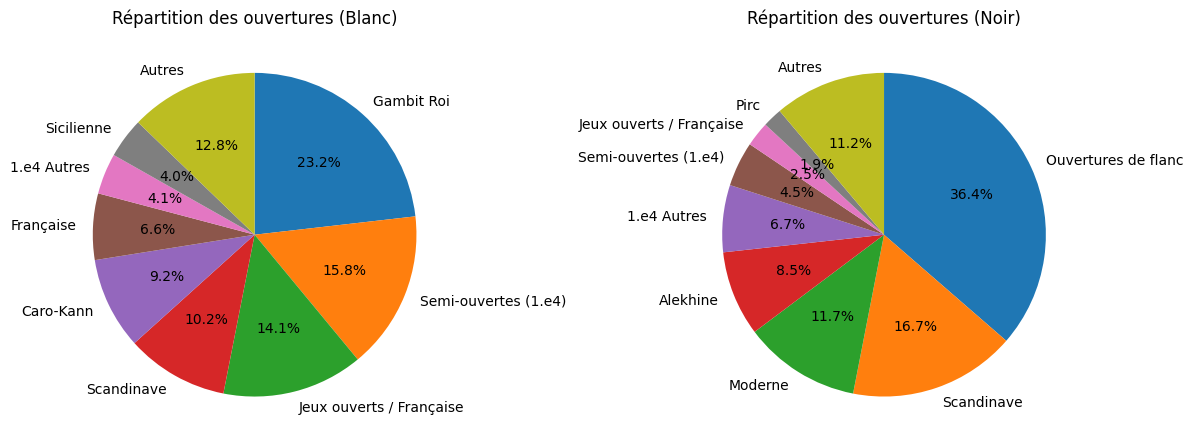

In [121]:
def top_openings_by_color(df, color, n=8):
    data = (df[df["color"]==color]["opening_simplified"]
               .fillna("Inconnue")
               .value_counts())
    top = data.head(n)
    autres = data.iloc[n:].sum()
    if autres > 0:
        top["Autres"] = autres
    return top

top_white = top_openings_by_color(df, "white")
top_black = top_openings_by_color(df, "black")

fig, axes = plt.subplots(1, 2, figsize=(12,6))

# Camembert Blanc
axes[0].pie(top_white, labels=top_white.index, autopct="%1.1f%%", 
            startangle=90, counterclock=False)
axes[0].set_title("Répartition des ouvertures (Blanc)")

# Camembert Noir
axes[1].pie(top_black, labels=top_black.index, autopct="%1.1f%%", 
            startangle=90, counterclock=False)
axes[1].set_title("Répartition des ouvertures (Noir)")

plt.tight_layout()
plt.show()



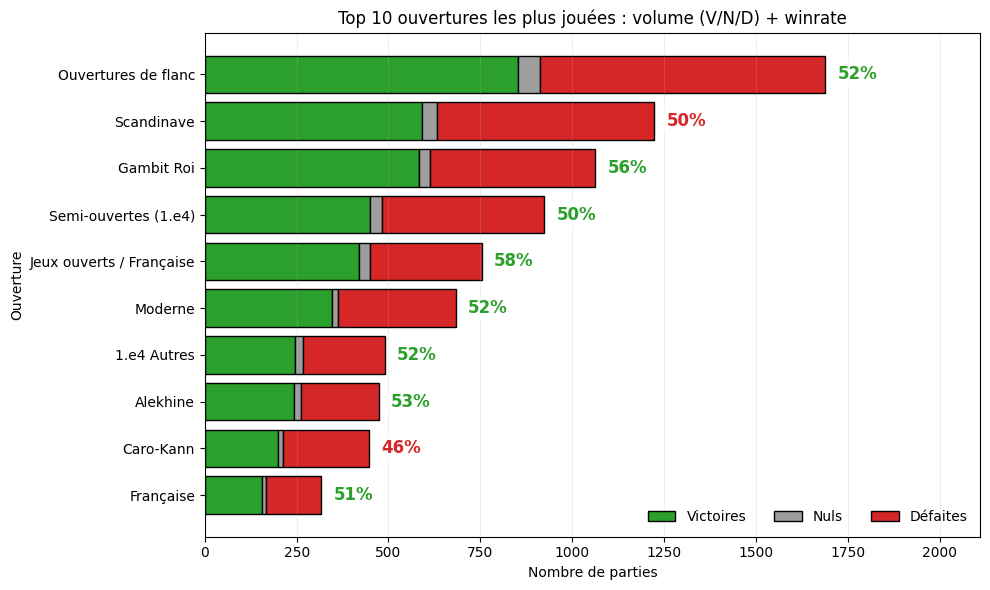

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# 1) Choix de la colonne d’ouverture la plus propre
if "opening_simplified" in df.columns:
    col_open = "opening_simplified"
elif "opening_family" in df.columns:
    col_open = "opening_family"
elif "opening" in df.columns:
    col_open = "opening"
else:
    col_open = "eco"

# 2) Top 10 par volume
base = df[col_open].fillna("Inconnue").astype(str)
top10 = base.value_counts().head(10).index
sub = df[base.isin(top10)].copy()
sub["open10"] = sub[col_open].fillna("Inconnue").astype(str)

# 3) Comptage V/N/D
counts = (sub.groupby(["open10","result"])
            .size()
            .unstack(fill_value=0)
            .reindex(columns=["win","draw","loss"], fill_value=0))

# 4) Tri par total décroissant (plus jouée en haut)
counts["total"] = counts.sum(axis=1)
counts = counts.sort_values("total", ascending=False)
totals = counts["total"].to_numpy()
wr = ((counts["win"] + 0.5*counts["draw"]) / totals) * 100
counts = counts.drop(columns="total")

# 5) Tracé barres empilées + labels de winrate bien visibles
fig, ax = plt.subplots(figsize=(10,6))
ypos = np.arange(len(counts))

ax.barh(ypos, counts["win"],  color="#2ca02c", edgecolor="black", label="Victoires")
ax.barh(ypos, counts["draw"], left=counts["win"],  color="#9e9e9e", edgecolor="black", label="Nuls")
ax.barh(ypos, counts["loss"], left=counts["win"]+counts["draw"], color="#d62728", edgecolor="black", label="Défaites")

ax.set_yticks(ypos)
ax.set_yticklabels(counts.index)
ax.invert_yaxis()
ax.set_xlabel("Nombre de parties")
ax.set_ylabel("Ouverture")
ax.legend(loc="lower right", ncol=3, frameon=False)
ax.grid(axis="x", alpha=0.2)

# Espace à droite pour loger les labels de % (et couleur verte/rouge selon 50%)
max_total = totals.max()
ax.set_xlim(0, max_total * 1.25)

for y, t, p in zip(ypos, totals, wr.values):
    color = "#2ca02c" if p >= 50 else "#d62728"
    ax.text(t + max_total*0.02, y, f"{p:.0f}%",
            va="center", ha="left",
            fontsize=12, fontweight="bold", color=color,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.9, boxstyle="round,pad=0.15"))

plt.title("Top 10 ouvertures les plus jouées : volume (V/N/D) + winrate")
plt.tight_layout()
plt.show()


# Evolution de mon élo chronologiquement
Dans ce chapitre, on verra comment mon élo à fluctué en fonction de la cadence jouée chronologiquement.

In [123]:
# 1) Construire "cadence" à partir de "time_control"
import pandas as pd

df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")  # au cas où
df["score"] = df["result"].map({"win":1, "draw":0.5, "loss":0})

def classify_tc(tc):
    if pd.isna(tc):
        return "Inconnu"
    s = str(tc)
    if "/" in s:                     # ex. '1/259200' = correspondance sur Chess.com
        return "Correspondance"
    base, inc = (s.split("+", 1) + ["0"])[:2]  # '300+0' ou '300'
    try:
        base, inc = int(base), int(inc)
    except ValueError:
        return "Inconnu"
    est = base + 40*inc              # temps estimé pour ~40 coups
    if est < 180:   return "Bullet"
    if est < 480:   return "Blitz"
    if est < 1500:  return "Rapide"
    return "Classique"

df["cadence"] = df["time_control"].apply(classify_tc)


In [124]:
# 2) Ordre d’affichage (et filtrage aux cadences présentes)
cadences = ["Bullet", "Blitz", "Rapide", "Correspondance"]
cadences_present = [c for c in cadences if (df["cadence"] == c).any()]


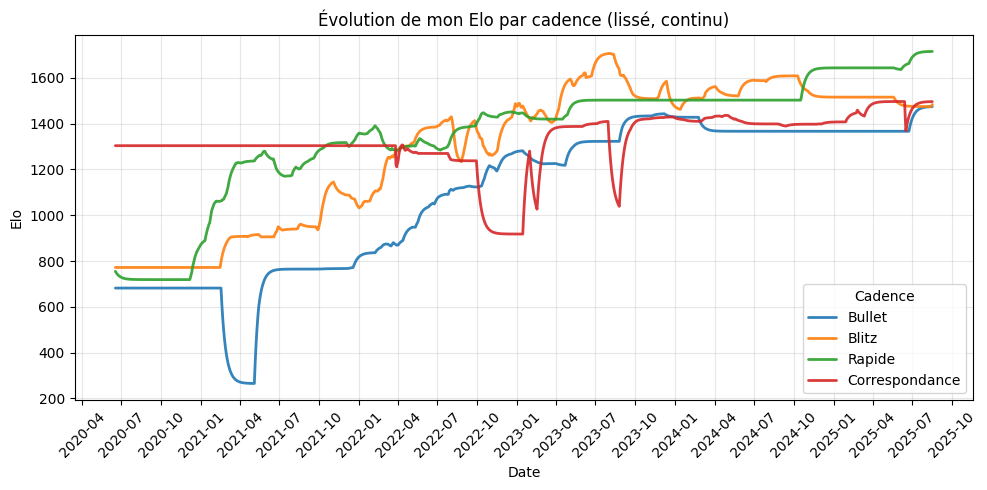

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# S'assurer du bon type
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

# Cadences à afficher (ordre souhaité) : on EXCLUT "Classique", on GARDE "Correspondance"
wanted = ["Bullet", "Blitz", "Rapide", "Correspondance"]
present = [c for c in wanted if (df["cadence"] == c).any()]

# Index quotidien global (du min au max)
start = df["datetime"].min().floor("D")
end   = df["datetime"].max().ceil("D")
date_index = pd.date_range(start, end, freq="D")

# Séries quotidiennes continues (ffill après la 1re partie)
series_by_cadence = {}
for c in present:
    d = (df[(df["cadence"]==c) & df["my_elo"].notna()]
         .sort_values("datetime")
         .set_index("datetime"))
    daily = d["my_elo"].resample("D").last().reindex(date_index)
    daily = daily.ffill()
    # ne rien tracer avant la 1re partie de cette cadence
    first_date = d.index.min().normalize()
    daily.loc[daily.index < first_date] = np.nan
    series_by_cadence[c] = daily

# Petit lissage "arrondi"
def smooth_series(s, span=21):
    s = s.interpolate("time", limit_direction="both")
    return s.ewm(span=span, adjust=False, min_periods=1).mean()

# Tracé
fig, ax = plt.subplots(figsize=(10,5))
for c, s in series_by_cadence.items():
    s_smooth = smooth_series(s, span=21)
    line, = ax.plot(s_smooth.index, s_smooth.values, label=c, linewidth=2, alpha=0.9)
    line.set_solid_capstyle('round')
    line.set_solid_joinstyle('round')

ax.set_title("Évolution de mon Elo par cadence (lissé, continu)")
ax.set_xlabel("Date"); ax.set_ylabel("Elo"); ax.grid(True, alpha=0.3)
ax.legend(title="Cadence")

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
